In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from pandas import DataFrame

<h3>Functions</h3>

In [2]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [3]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [4]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [5]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [6]:
def conf_mat_disp(confusion_matrix, disp_labels):
    
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                  display_labels = disp_labels)
        
        disp.plot(cmap = 'OrRd')

In [7]:
def draw_roc_curve(Y_test, Y_pred):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", title="AUC", fontsize=14, frameon=True)
    
    fig.tight_layout()
    plt.show()

In [8]:
def draw_precision_recall_curve(Y_test, Y_pred):
    
    fig, ax = plt.subplots()
    
    pr_ap = average_precision_score(Y_test, Y_pred, average = None)
    precision, recall, ap_thresholds = precision_recall_curve(Y_test, Y_pred)
    
    ax.plot(precision, recall, color = "#994D00", label='AP %0.4f' % (pr_ap))
    #ax.plot([0, 1], [no_skill, no_skill], 'r--', label='%0.4f' % no_skill) 
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision') 
    ax.tick_params(axis='both')
    ax.legend(loc="upper right", title="AP", frameon=True)
    ax.set_title("Model Precision-Recall curve")
    
    fig.tight_layout()
    plt.show()

In [9]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print("Classification report")
    print(classification_report(y_test, y_pred_adj))
    print()
    print("Confusion matrix")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    print()
    cm = confusion_matrix(y_test, y_pred_adj)
    print(cm)
    print()
    
    conf_mat_disp(cm, clf.classes_)

    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve (^ = current threshold)")
    plt.step(r, p, color='#994D00', alpha=0.5,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.5,
                     color='#994D00')
    plt.ylim([0, 1.0]);
    plt.xlim([0, 1.0]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^',
            markersize=15, mfc = "#800000", mec = "#800000")
    
    return y_pred_adj

<h3>Dataset</h3>

In [10]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [11]:
df_TEST = pd.read_csv("One_Hot_Encoding_Test_HR_Employee_Attrition.csv")

In [12]:
df.head()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [14]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


In [15]:
df_TEST.head()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,27,1,0,0,1,15,2,1,0,1,...,14,4,2,1,2,2,2,374.542373,0.805503,2.4
1,30,1,0,1,0,16,4,1,0,3,...,13,1,3,2,3,8,0,271.457143,0.720871,2.2
2,56,0,1,0,0,2,4,4,0,3,...,11,3,1,2,2,13,3,290.550000,0.638272,3.2
3,41,1,0,1,0,18,5,4,0,4,...,17,3,0,4,3,3,0,241.516854,0.700861,3.0
4,42,0,0,1,0,1,3,4,0,3,...,22,1,1,6,3,5,3,281.736842,0.870820,3.0


In [16]:
df_TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     219 non-null    int64  
 1   Attrition                               219 non-null    int64  
 2   BusinessTravel_Non-Travel               219 non-null    int64  
 3   BusinessTravel_Travel_Rarely            219 non-null    int64  
 4   BusinessTravel_Travel_Frequently        219 non-null    int64  
 5   DistanceFromHome                        219 non-null    int64  
 6   Education                               219 non-null    int64  
 7   EnvironmentSatisfaction                 219 non-null    int64  
 8   Gender                                  219 non-null    int64  
 9   JobInvolvement                          219 non-null    int64  
 10  JobLevel                                219 non-null    int64 

In [17]:
df_TEST = df_TEST.drop(['JobRole_Manager'], axis=1)

In [18]:
df_TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     219 non-null    int64  
 1   Attrition                               219 non-null    int64  
 2   BusinessTravel_Non-Travel               219 non-null    int64  
 3   BusinessTravel_Travel_Rarely            219 non-null    int64  
 4   BusinessTravel_Travel_Frequently        219 non-null    int64  
 5   DistanceFromHome                        219 non-null    int64  
 6   Education                               219 non-null    int64  
 7   EnvironmentSatisfaction                 219 non-null    int64  
 8   Gender                                  219 non-null    int64  
 9   JobInvolvement                          219 non-null    int64  
 10  JobLevel                                219 non-null    int64 

In [19]:
df_TEST.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,36.447489,0.155251,0.086758,0.703196,0.210046,8.922374,3.022831,2.794521,0.319635,2.698630,...,15.264840,2.694064,0.844749,2.557078,2.762557,6.625571,3.949772,243.550215,0.435109,2.757991
std,8.379788,0.362974,0.282125,0.457896,0.408274,7.912851,1.051181,1.070354,0.467403,0.710697,...,3.717452,1.019314,0.842456,1.292243,0.702724,4.600208,3.227212,135.584686,0.327108,0.420646
min,22.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,33.715909,0.000000,1.400000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,125.273516,0.053626,2.400000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,230.823529,0.474904,2.800000
75%,41.500000,0.000000,0.000000,1.000000,0.000000,12.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,3.000000,1.000000,3.000000,3.000000,9.000000,7.000000,334.847370,0.750167,3.000000
max,58.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,15.000000,574.795455,0.913868,3.600000


<h3>Feature selection</h3>

In [20]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.029401
JobRole_Sales_Representative                       0.010875
JobSatisfaction                                    0.009684
JobRole_Research_Scientist                         0.007331
JobRole_Manufacturing_Director                     0.007301
JobRole_Laboratory_Technician                      0.007288
StockOptionLevel                                   0.007166
EnvironmentSatisfaction                            0.006880
RelationshipSatisfaction                           0.006659
JobInvolvement                                     0.006612
WorkLifeBalance                                    0.005754
NumCompaniesWorked                                 0.004162
TrainingTimesLastYear                              0.004053
Age                                                0.003875
OverallSatisfaction                                0.003627
YearsInCurrentRole                                 0.003230
JobRole_Healthcare_Representative       

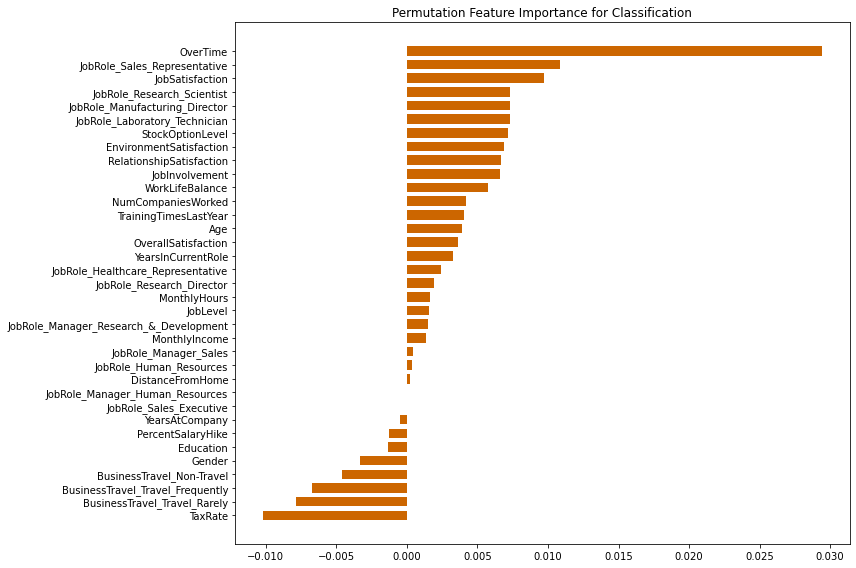

In [21]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [22]:
df = df.drop(['YearsInCurrentRole','JobRole_Manager_Sales',
              'JobRole_Manager_Human_Resources', 'JobRole_Sales_Executive',
              'JobRole_Human_Resources','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel_Non-Travel',
              'PercentSalaryHike','BusinessTravel_Travel_Frequently',
              'BusinessTravel_Travel_Rarely','TaxRate', 'JobRole_Healthcare_Representative'], axis = 1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Age                                     883 non-null    int64
 1   Attrition                               883 non-null    int64
 2   DistanceFromHome                        883 non-null    int64
 3   EnvironmentSatisfaction                 883 non-null    int64
 4   JobInvolvement                          883 non-null    int64
 5   JobLevel                                883 non-null    int64
 6   JobRole_Laboratory_Technician           883 non-null    int64
 7   JobRole_Manager_Research_&_Development  883 non-null    int64
 8   JobRole_Manufacturing_Director          883 non-null    int64
 9   JobRole_Research_Director               883 non-null    int64
 10  JobRole_Research_Scientist              883 non-null    int64
 11  JobRole_Sales_Repre

In [24]:
df_TEST = df_TEST.drop(['YearsInCurrentRole','JobRole_Manager_Sales',
              'JobRole_Manager_Human_Resources', 'JobRole_Sales_Executive',
              'JobRole_Human_Resources','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel_Non-Travel',
              'PercentSalaryHike','BusinessTravel_Travel_Frequently',
              'BusinessTravel_Travel_Rarely','TaxRate', 'JobRole_Healthcare_Representative'], axis = 1)

In [25]:
df_TEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     219 non-null    int64  
 1   Attrition                               219 non-null    int64  
 2   DistanceFromHome                        219 non-null    int64  
 3   EnvironmentSatisfaction                 219 non-null    int64  
 4   JobInvolvement                          219 non-null    int64  
 5   JobLevel                                219 non-null    int64  
 6   JobRole_Laboratory_Technician           219 non-null    int64  
 7   JobRole_Manager_Research_&_Development  219 non-null    int64  
 8   JobRole_Manufacturing_Director          219 non-null    int64  
 9   JobRole_Research_Director               219 non-null    int64  
 10  JobRole_Research_Scientist              219 non-null    int64 

<h3>Discretization with KBinsDiscretizer and Column Transformer</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [26]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [27]:
remaining_columns = []

for column in columns_to_discretize:
    if column in df:
        remaining_columns.append(column)
        
remaining_columns

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [28]:
columns_to_discretize = remaining_columns
columns_to_discretize

['Age', 'DistanceFromHome', 'NumCompaniesWorked']

In [29]:
ct = ColumnTransformer([('k_means_discretizer', 
                         KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'kmeans'),
                        ['Age','DistanceFromHome','NumCompaniesWorked'])], 
                       remainder = "drop")

<h4>Discretization of the training set</h4>

In [30]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


In [31]:
df_temp = pd.DataFrame(ct.fit_transform(df), columns = columns_to_discretize)
df_temp.head()

,Age,DistanceFromHome,NumCompaniesWorked
0,3.0,1.0,3.0
1,1.0,0.0,0.0
2,0.0,2.0,0.0
3,1.0,0.0,0.0
4,1.0,1.0,0.0


In [32]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


In [33]:
for column in df_temp:
    if column in df:
        df[column] = df_temp[column]

In [34]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,3.0,0,1.0,2,3,3,0,0,0,1,0,0,3,3.0,0,3,0,2,2,2
1,1.0,0,0.0,2,3,5,0,1,0,0,0,0,3,0.0,1,3,1,3,3,2
2,0.0,0,2.0,3,3,2,0,0,0,0,0,0,4,0.0,1,3,1,4,3,3
3,1.0,0,0.0,2,3,1,0,0,0,0,1,0,2,0.0,0,2,0,1,3,2
4,1.0,0,1.0,3,3,1,1,0,0,0,0,0,4,0.0,0,3,0,2,3,3


<h4>Discretization of the test set</h4>

In [35]:
df_TEST.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,27,1,15,1,1,2,0,0,0,0,0,0,4,6,1,4,2,1,2,2.4
1,30,1,16,1,3,3,0,0,0,0,0,0,3,2,0,1,3,2,3,2.2
2,56,0,2,4,3,2,0,0,1,0,0,0,4,2,0,3,1,2,2,3.2
3,41,1,18,4,4,1,0,0,0,0,0,0,1,0,0,3,0,4,3,3.0
4,42,0,1,4,3,1,0,0,0,0,1,0,4,3,0,1,1,6,3,3.0


In [36]:
df_TEST_temp = pd.DataFrame(ct.fit_transform(df_TEST), columns = columns_to_discretize)
df_TEST_temp.head()

,Age,DistanceFromHome,NumCompaniesWorked
0,0.0,2.0,2.0
1,0.0,2.0,0.0
2,3.0,0.0,0.0
3,2.0,2.0,0.0
4,2.0,0.0,1.0


In [37]:
df_TEST.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,27,1,15,1,1,2,0,0,0,0,0,0,4,6,1,4,2,1,2,2.4
1,30,1,16,1,3,3,0,0,0,0,0,0,3,2,0,1,3,2,3,2.2
2,56,0,2,4,3,2,0,0,1,0,0,0,4,2,0,3,1,2,2,3.2
3,41,1,18,4,4,1,0,0,0,0,0,0,1,0,0,3,0,4,3,3.0
4,42,0,1,4,3,1,0,0,0,0,1,0,4,3,0,1,1,6,3,3.0


In [38]:
for column in df_TEST_temp:
    if column in df_TEST:
        df_TEST[column] = df_TEST_temp[column]

In [39]:
df_TEST.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,0.0,1,2.0,1,1,2,0,0,0,0,0,0,4,2.0,1,4,2,1,2,2.4
1,0.0,1,2.0,1,3,3,0,0,0,0,0,0,3,0.0,0,1,3,2,3,2.2
2,3.0,0,0.0,4,3,2,0,0,1,0,0,0,4,0.0,0,3,1,2,2,3.2
3,2.0,1,2.0,4,4,1,0,0,0,0,0,0,1,0.0,0,3,0,4,3,3.0
4,2.0,0,0.0,4,3,1,0,0,0,0,1,0,4,1.0,0,1,1,6,3,3.0


<h3>Divide into features and target</h3>

In [40]:
attributes = [col for col in df.columns if col != 'Attrition']

X_train = df[attributes].values
y_train = df['Attrition']

In [41]:
X_test = df_TEST[attributes].values
y_test = df_TEST['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

Results of the grid search

Best score ('roc_auc'): 0.6339785466187537
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


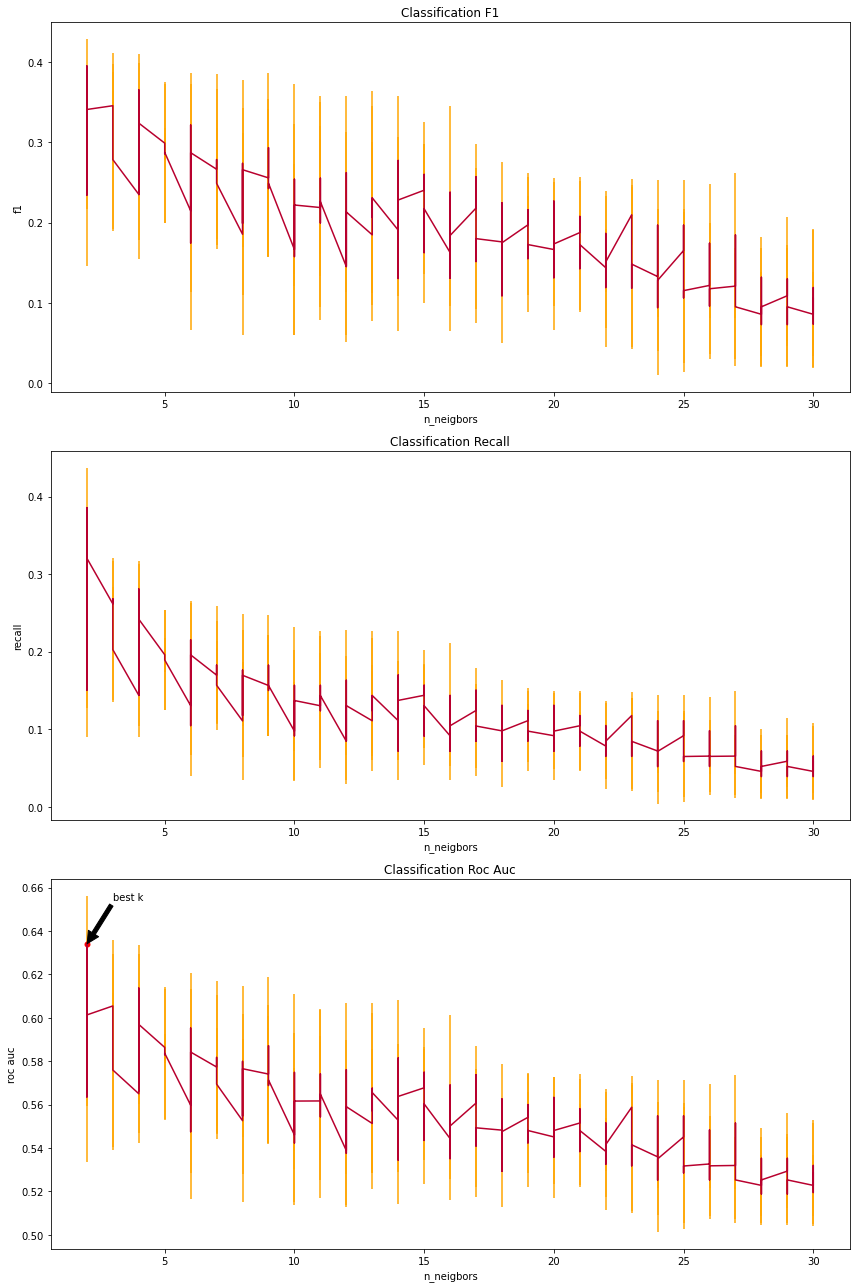



Permutation importances of the training set

OverTime                                           0.007659
JobSatisfaction                                    0.003161
JobRole_Sales_Representative                       0.003011
DistanceFromHome                                   0.001421
EnvironmentSatisfaction                            0.000602
JobRole_Research_Scientist                         0.000266
RelationshipSatisfaction                           0.000098
JobRole_Laboratory_Technician                      0.000067
Age                                                0.000035
NumCompaniesWorked                                 0.000021
StockOptionLevel                                   0.000017
WorkLifeBalance                                    0.000009
JobRole_Research_Director                          0.000005
TrainingTimesLastYear                              0.000003
JobLevel                                           0.000002
JobInvolvement                                     0.

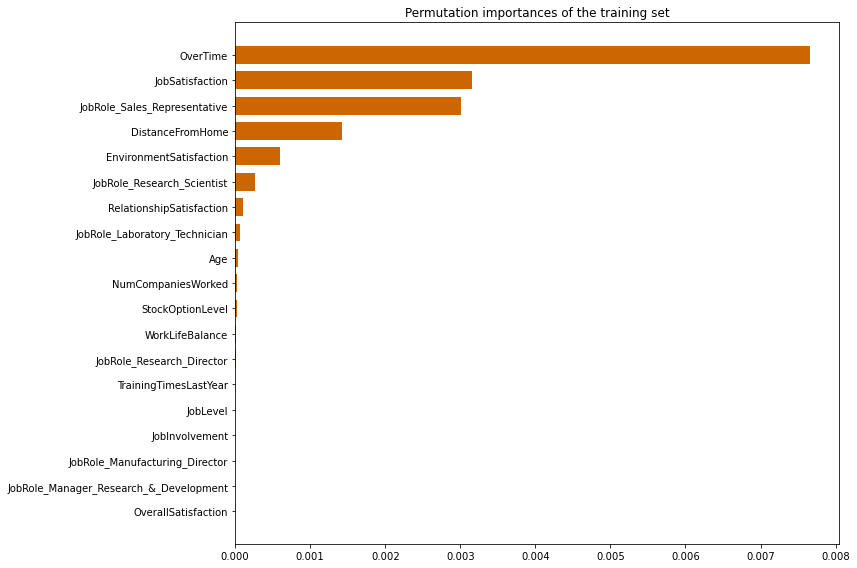



Predictions

Permutation importances of the test set

OverTime                                           0.103577
JobSatisfaction                                    0.027075
JobRole_Sales_Representative                       0.026200
JobRole_Research_Scientist                         0.024579
NumCompaniesWorked                                 0.022750
StockOptionLevel                                   0.019523
JobRole_Laboratory_Technician                      0.012353
WorkLifeBalance                                    0.009507
JobLevel                                           0.008665
RelationshipSatisfaction                           0.008482
JobRole_Research_Director                          0.007544
JobInvolvement                                     0.007369
EnvironmentSatisfaction                            0.005548
OverallSatisfaction                                0.003474
JobRole_Manager_Research_&_Development             -0.000032
Age                                        

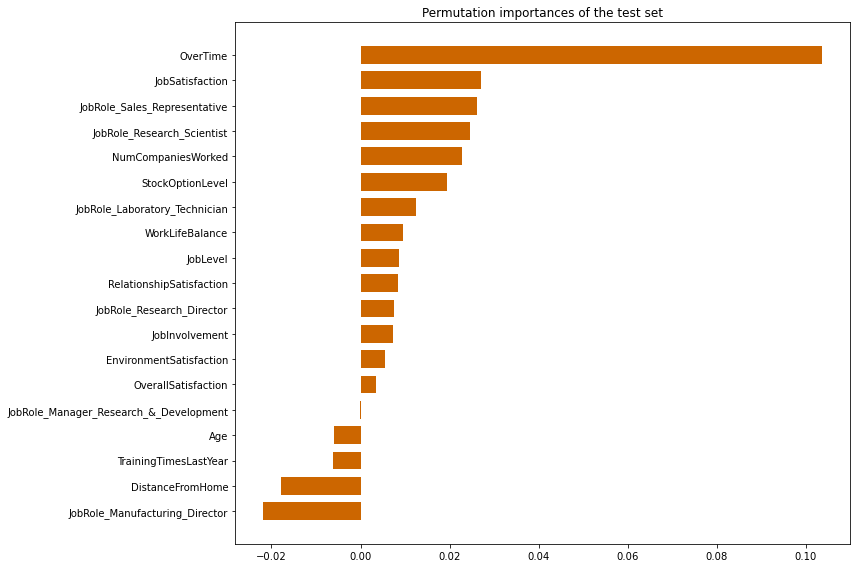



Confusion matrix


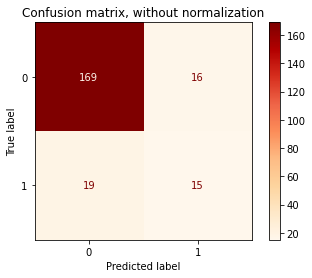

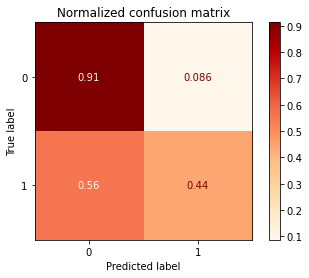


Classification report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       185
           1       0.48      0.44      0.46        34

    accuracy                           0.84       219
   macro avg       0.69      0.68      0.68       219
weighted avg       0.83      0.84      0.84       219


Metrics

Accuracy 0.8401826484018264
F1-score [0.90616622 0.46153846]
Precision [0.89893617 0.48387097]
Recall [0.91351351 0.44117647]
Roc_auc 0.6773449920508744


Roc curve



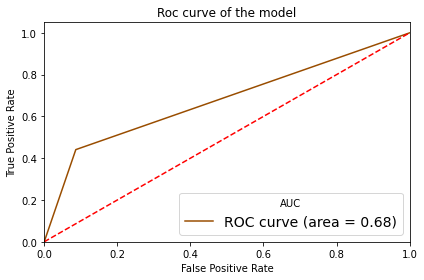

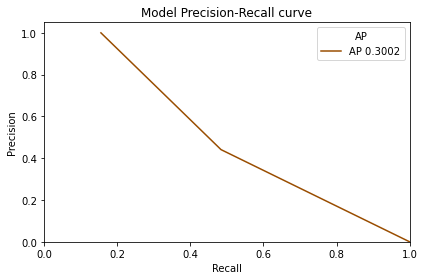

In [42]:
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
    
    
#normalization
scaler = MinMaxScaler()
    
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)
    
#classifier
clf = KNeighborsClassifier()
    
#parameter list for the grid search
param_list = {'n_neighbors': k_range,
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
    
#grid search
grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
grid_search.fit(X_train_normalized, y_train)
    
#results of the grid search
print('\033[1m'"Results of the grid search"'\033[0m')
print()
print("Best score ('roc_auc'): %s" % grid_search.best_score_)
print("Best parameters: %s" % grid_search.best_params_)
print("Best estimator: %s" % grid_search.best_estimator_)
print()
print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
print()
    
#plot grid search results
print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
print()
print()
    
clf = grid_search.best_estimator_ #select the best estimator
    
#perform permutation importance of the training set
    
results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
#print results of permutation importance of the training set
title1 = "Permutation importances of the training set"
print('\033[1m'+title1+'\033[0m')
print()
    
train_sorted_feature_importances = results_permutation_importance(results1, attributes)
for t in train_sorted_feature_importances:
    print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
print()
plot_permutation_importance(results1, attributes, title1)
    
print()
print()
    

#Predictions
    
print('\033[1m'"Predictions"'\033[0m')
print()
    
y_pred = clf.predict(X_test_normalized)  #predict
    
    
# perform permutation importance of the test set
    
results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
#print results of permutation importance of the train
title2 = "Permutation importances of the test set"
print('\033[1m'+title2+'\033[0m')
print()
    
test_sorted_feature_importances = results_permutation_importance(results2, attributes)
for t in test_sorted_feature_importances:
    print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
print()
plot_permutation_importance(results2, attributes, title2)
    
print()
print()
    
    
#confusion matrix
print('\033[1m'"Confusion matrix"'\033[0m')
    
#plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
draw_confusion_matrix(clf, X_test_normalized, y_test)
        
print()
        
print('\033[1m'"Classification report"'\033[0m')
print(classification_report(y_test, y_pred))
        
print()
        
print('\033[1m'"Metrics"'\033[0m')
print()
        
print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
print()
print()
    
#plot the Roc Curve of the model
print('\033[1m'"Roc curve"'\033[0m')
print()
draw_roc_curve(y_test, y_pred)
print()

draw_precision_recall_curve(y_test, y_pred)


In [43]:
y_scores = clf.predict_proba(X_test_normalized)[:, 1]

In [44]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

Classification report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       185
           1       0.46      0.50      0.48        34

    accuracy                           0.83       219
   macro avg       0.68      0.70      0.69       219
weighted avg       0.84      0.83      0.83       219


Confusion matrix
     pred_neg  pred_pos
neg       165        20
pos        17        17

[[165  20]
 [ 17  17]]



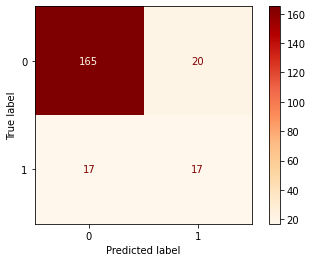

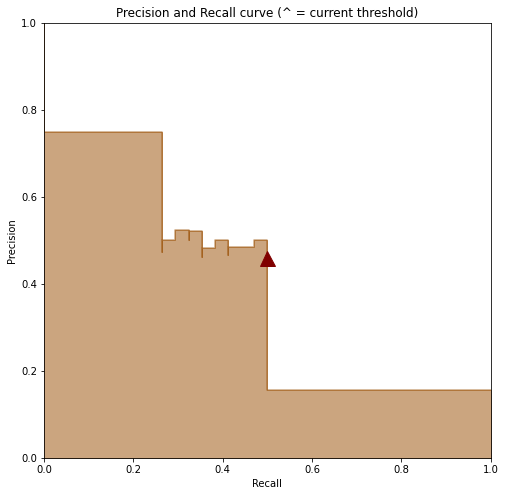

In [72]:
y_pred_adj = precision_recall_threshold(p, r, thresholds, 0.48)

In [73]:
threshold_accuracy = accuracy_score(y_test, y_pred_adj)
rocAuc = roc_auc_score(y_test, y_pred_adj, average=None)
average_precision = average_precision_score(y_test, y_pred_adj, average = None)

print('Accuracy score: {0:0.2f}'.format(threshold_accuracy))
print('Roc Auc score: {0:0.2f}'.format(rocAuc))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Accuracy score: 0.83
Roc Auc score: 0.70
Average precision-recall score: 0.31


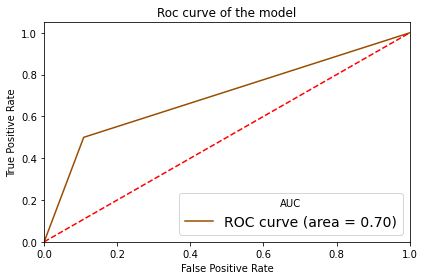

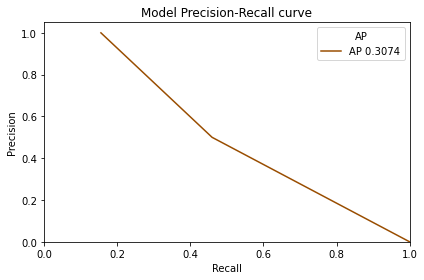

In [74]:
draw_roc_curve(y_test, y_pred_adj)
print()

draw_precision_recall_curve(y_test, y_pred_adj)